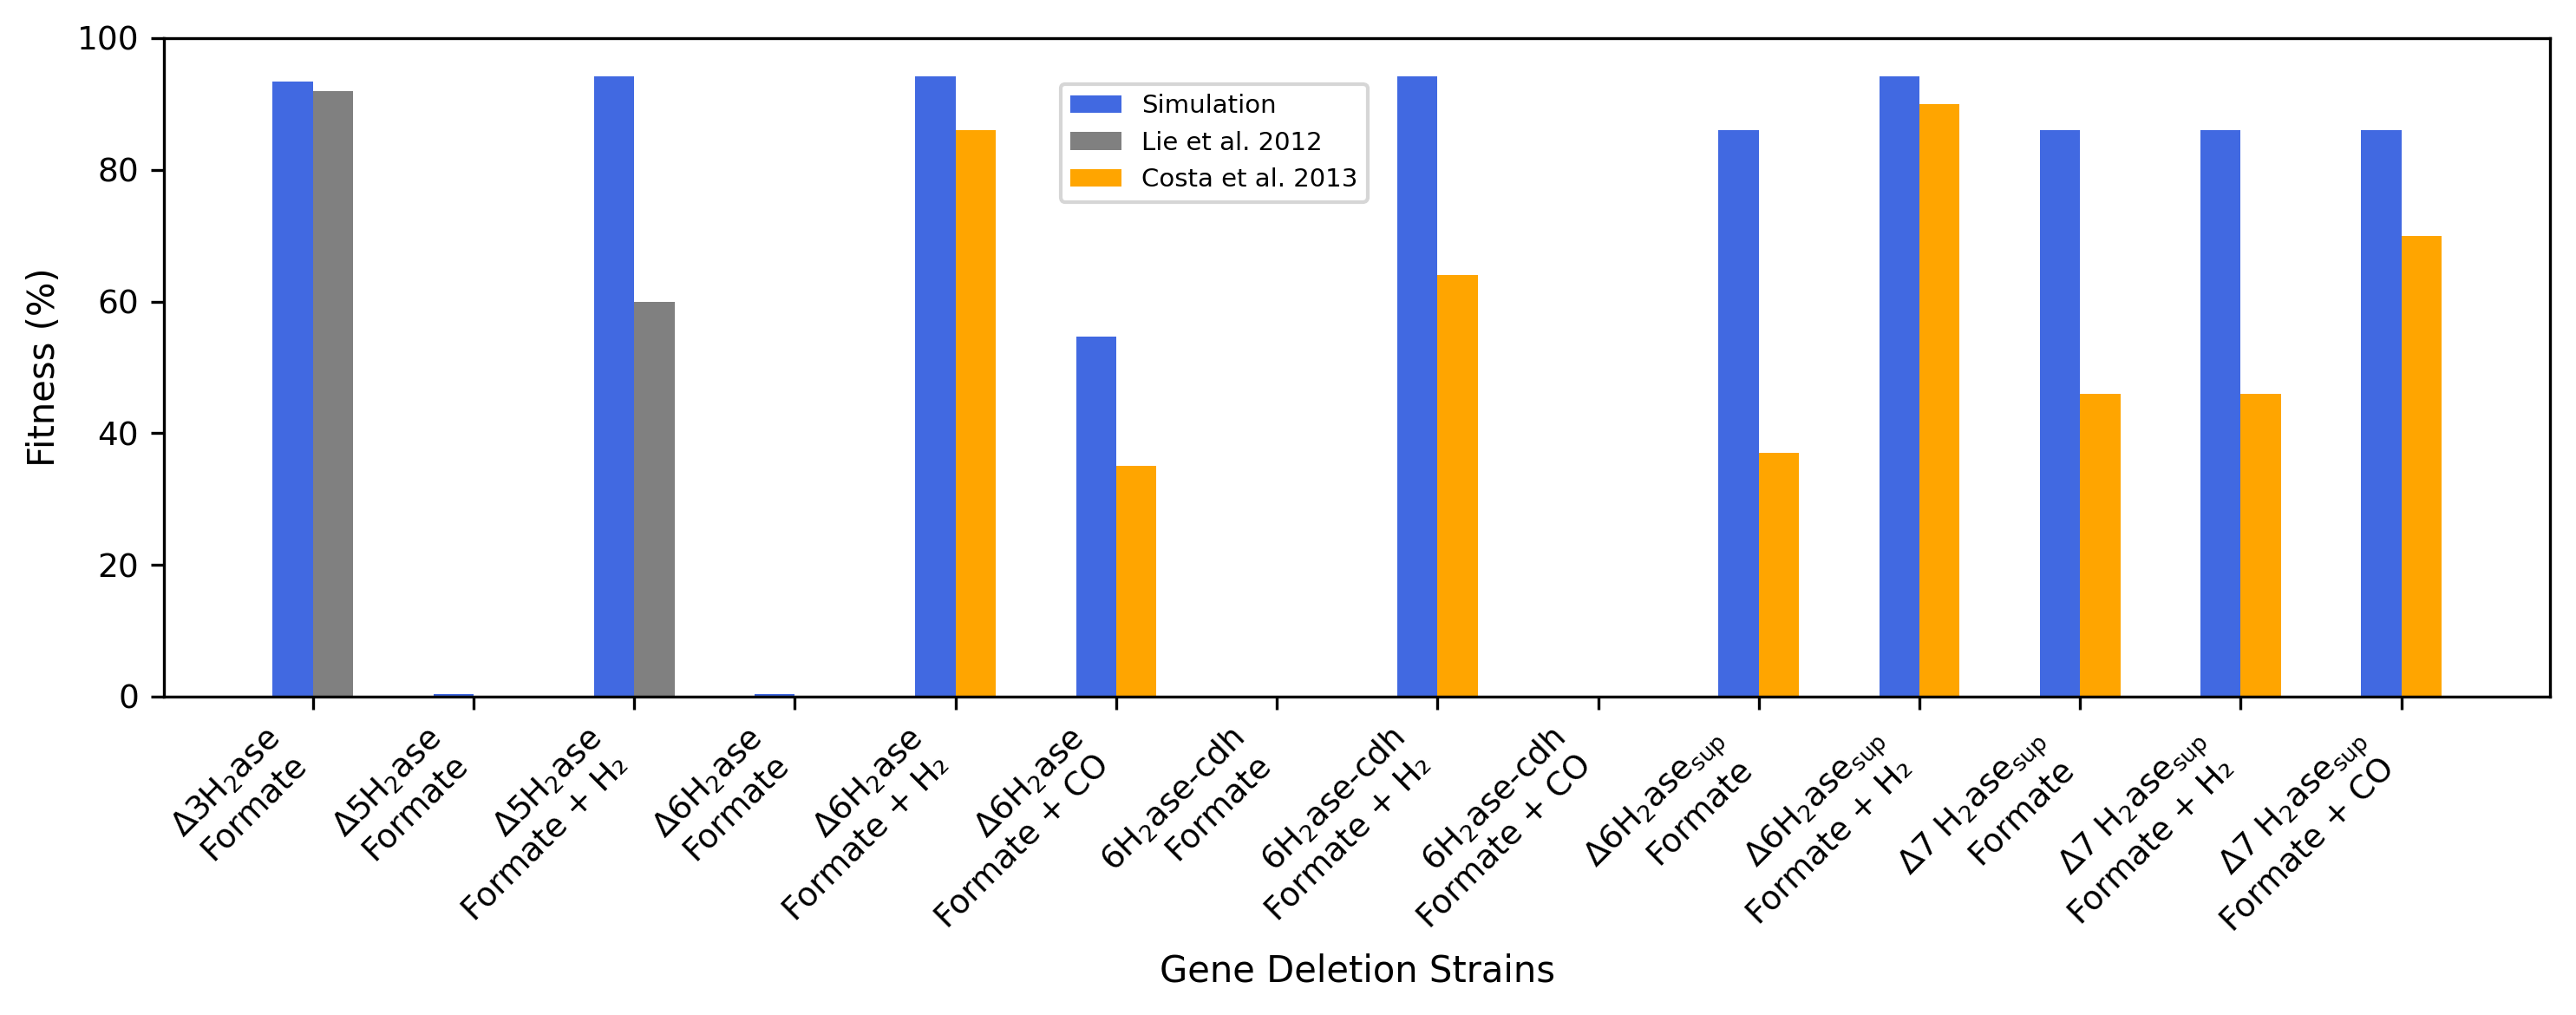

,Condition,KO Type,Fitness (%)
0,Formate,3H2ase KO,93.415098
1,Formate,5H2ase KO,0.403358
2,Formate + H2,5H2ase KO,94.238211
3,Formate,6H2ase KO,0.403358
4,Formate + H2,6H2ase KO,94.238211
5,Formate + CO,6H2ase KO,54.728799
6,Formate,6H2ase-cdh KO,NaN
7,Formate + H2,6H2ase-cdh KO,94.238211
8,Formate + CO,6H2ase-cdh KO,NaN
9,Formate,6H2ase_supp KO (with GAPOR),86.007083


In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
total_protein_mass = 0.6
up_ratio = 0.44 * total_protein_mass
excel_file = "pcMMP.xlsx"
model_file='pcMMP.xml'
gene_knockout_sets= {
    'Wild Type': ['MMP0680'],
    '3H2ase KO': ['MMP0680', 'MMP0820', 'MMP0818', 'MMP0817', 'MMP1382', 'MMP1384', 'MMP1385', 'MMP0127'],
    '5H2ase KO': ['MMP0680', 'MMP0820', 'MMP1382', 'MMP0127', 'MMP1694', 'MMP1693', 'MMP0823'],
    '6H2ase KO': ['MMP0680', 'MMP0820', 'MMP1382', 'MMP0127', 'MMP1694', 'MMP1693', 'MMP0823', 'MMP1153'],
    '6H2ase_supp KO (with GAPOR)': ['MMP0680', 'MMP0820', 'MMP1382', 'MMP0127', 'MMP1694', 'MMP1693', 'MMP0823', 'MMP1153'],
    '6H2ase-cdh KO': ['MMP0680', 'MMP0820', 'MMP1382', 'MMP0127', 'MMP1694', 'MMP1693', 'MMP0823', 'MMP1153', 'MMP0983', 'MMP0984', 'MMP0985'],
    '7H2ase_supp KO (with GAPOR)': ['MMP0680', 'MMP0820', 'MMP1382', 'MMP0127', 'MMP1694', 'MMP1693', 'MMP0823', 'MMP1153', 'MMP1461', 'MMP1462']
}


def apply_gene_knockouts(model, knockout_sets, condition):
    results = []
    name_condition = condition.replace('+', '_').replace(' ', '')

    for i, (label, genes) in enumerate(knockout_sets.items()):
        model.file_path=f'output/lp_file_gene_deletion_{name_condition}_{i}.lp' 
        model.output_file=f'output/output_gene_deletion_{name_condition}_{i}.lp'
        if isinstance(genes, str):
            genes = [genes]
        
        model.set_constraint = [f"UP >= {up_ratio}"]
        
        for gene in genes:
            df = model.lp_file_constraints.gene_protein_sheet
            translation_id = df.loc[df['Gene_Name'] == gene, 'translation_reaction_ID'].values[0]
            model.set_constraint.append(f"{translation_id} = 0")
        
        if "with GAPOR" not in label:
            model.set_constraint += ["R131 = 0"]
        
        growth = model.search_max_growth_rate(0, 0.5)
        results.append({
            'KO Type': label,
            'Genes Knocked Out': ', '.join(genes),
            f'{condition}': growth
        })
        
       
    return pd.DataFrame(results)

def simulate_gene_knockouts(selected_ko_labels, closed_reactions, objective, condition):
    sim = Simulation()
    sim.set_parameter(model_file=model_file, objective=objective, GAM=25, NGAM=1,
                       excel_file=excel_file)
    sim.close_reactions(closed_reactions)
    selected_knockouts = {
        label: gene_knockout_sets[label]
        for label in selected_ko_labels
        if label in gene_knockout_sets
    }
    return apply_gene_knockouts(sim, selected_knockouts, condition)


def calculate_fitness(result_df, ko_type, condition, wt_growth):
    df = result_df.loc[result_df['KO Type'] == ko_type, condition]
    
    if pd.isna(df.values[0]):
        return None  

    mutant_strain_growth_rate = df.values[0]
    fitness = mutant_strain_growth_rate / wt_growth
    fitness = fitness*100
    return fitness

def plot_fitness_comparison(formate_result, h2_result, co_result, calculate_fitness):
  
    plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize":9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7
})
    
    colors = {'lie': 'gray', 'costa': 'orange', 'simulation': 'royalblue'}

    # Experimental data from Lie et al. and Costa et al.
    exp_data = [
        92,None, 60, None,86,35
        ,None,64,None,
       37, 90, 46, 46,70
    ]

   
    conditions = [
        ('∆3H$_2$ase\nFormate', '3H2ase KO', 'Formate', formate_result),
        ('∆5H$_2$ase\nFormate', '5H2ase KO', 'Formate', formate_result),
        ('∆5H$_2$ase\nFormate + H₂', '5H2ase KO', 'Formate + H2', h2_result),
        ('∆6H$_2$ase\nFormate', '6H2ase KO', 'Formate', formate_result),
        ('∆6H$_2$ase\nFormate + H₂', '6H2ase KO', 'Formate + H2', h2_result),
        ('∆6H$_2$ase\nFormate + CO', '6H2ase KO', 'Formate + CO', co_result),
        
        
        ('6H$_2$ase-cdh\nFormate', '6H2ase-cdh KO', 'Formate', formate_result),
        ('6H$_2$ase-cdh\nFormate + H₂', '6H2ase-cdh KO', 'Formate + H2', h2_result),
        ('6H$_2$ase-cdh\nFormate + CO', '6H2ase-cdh KO', 'Formate + CO', co_result),
        
        ('∆6H$_2$ase$_{\mathrm{sup}}$\nFormate', '6H2ase_supp KO (with GAPOR)', 'Formate', formate_result),
        ('∆6H$_2$ase$_{\mathrm{sup}}$\nFormate + H₂', '6H2ase_supp KO (with GAPOR)', 'Formate + H2', h2_result),
        ('∆7 H$_2$ase$_{\mathrm{sup}}$\nFormate', '7H2ase_supp KO (with GAPOR)', 'Formate', formate_result),
        ('∆7 H$_2$ase$_{\mathrm{sup}}$\nFormate + H₂', '7H2ase_supp KO (with GAPOR)', 'Formate + H2', h2_result),
        ('∆7 H$_2$ase$_{\mathrm{sup}}$\nFormate + CO', '7H2ase_supp KO (with GAPOR)', 'Formate + CO', co_result)
    ]

   
    wild_type = formate_result.loc[formate_result['KO Type'] == 'Wild Type', 'Formate'].values[0]
    simulation_data = []
    fitness_df=[]
    for condition_name, ko_type, substrate, df in conditions:
        value = calculate_fitness(df, ko_type, substrate, wild_type)
        simulation_data.append(value if not pd.isna(value) else None)
        fitness_df.append({"Condition": substrate,"KO Type": ko_type,"Fitness (%)": value})

    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    x = np.arange(len(conditions))
    width = 0.25
    exp_colors = [colors['lie'] if ('∆3H$_2$ase' in c[0] or '∆5H$_2$ase' in c[0]) else colors['costa'] for c in conditions]
    exp_labels = ['Lie et al. 2012' if ('∆3H$_2$ase' in c[0] or '∆5H$_2$ase' in c[0]) else 'Costa et al. 2013' for c in conditions]
    for i, ((sim, exp), condition) in enumerate(zip(zip(simulation_data, exp_data), conditions)):
        
        sim_x = x[i] - width / 2
        exp_x = x[i] + width / 2

        color = colors['lie'] if ('∆3H$_2$ase' in condition[0] or '∆5H$_2$ase' in condition[0]) else colors['costa']
        label = 'Lie et al. 2012' if ('∆3H$_2$ase' in condition[0] or '∆5H$_2$ase' in condition[0]) else 'Costa et al. 2013'

        ax.bar(sim_x, sim if sim is not None else 0, width, color=colors['simulation'], label='Simulation' if i == 0 else None)

        ax.bar(exp_x, exp if exp is not None else 0, width, color=color, label=label if i == 0 or label != exp_labels[i - 1] else None)
   
    ax.set_ylabel('Fitness (%)')
    ax.set_xlabel('Gene Deletion Strains')
    ax.set_xticks(x)
    ax.set_xticklabels([c[0] for c in conditions], rotation=45, ha='right')
    ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.44, 0.95), 
   
  
)
    ax.set_ylim(0,100)

    plt.tight_layout()
    plt.savefig("Figures/fitness_comparison.png", dpi=200)
    plt.show()
    return pd.DataFrame(fitness_df)

def run_simulation():
    # 1. Formate
    formate_ko = ['Wild Type','3H2ase KO','5H2ase KO','6H2ase KO',
    '6H2ase_supp KO (with GAPOR)','6H2ase-cdh KO','7H2ase_supp KO (with GAPOR)']
    formate_closed_rxns = ["R946", "R913", "R1165"]
    formate_result = simulate_gene_knockouts(formate_ko, formate_closed_rxns, 'R895', 'Formate')
            # 2. Formate + H2
    h2_ko = ['5H2ase KO','6H2ase KO','6H2ase-cdh KO','6H2ase_supp KO (with GAPOR)', '7H2ase_supp KO (with GAPOR)']
    h2_closed_rxns = ["R913", "R1165"]
    h2_result = simulate_gene_knockouts(h2_ko, h2_closed_rxns, 'R895', 'Formate + H2')
            # 3. Formate + CO 
    co_ko = ['6H2ase KO', '6H2ase-cdh KO', '7H2ase_supp KO (with GAPOR)']
    co_closed_rxns = ["R946", "R913"]
    co_result = simulate_gene_knockouts(co_ko, co_closed_rxns, 'R895', 'Formate + CO')
    fitness_df=plot_fitness_comparison(formate_result, h2_result, co_result, calculate_fitness) 
    return fitness_df  

if __name__ == "__main__":
    
      fitness_df=run_simulation()
      display(fitness_df)  
